# Synthetix Perps V2 Funding

This project provides a Python based sample implementation of the new funding model described in [SIP-279](https://sips.synthetix.io/sips/sip-279/) for Perps V2. The new funding model aims to optimise for a perfectly balanced skew. To recap the basics,

1. A perps market is a Synth/sUSD pair e.g. sETH/sUSD
1. A market skew is present when longs and shorts don't balance out e.g. 1M short, 2M long has a 1M long skew
1. When a skew is present, the skewed direction pays the opposite defined by a 'funding rate' e.g. 1M longs pay shorts. This is meant to incentivise arbers to short on Synthetix and long on another exchange, reducing skew back to equilibrium

The current mainnet implementation of [SIP-80](https://sips.synthetix.io/sips/sip-80/) poses two problems:

1. There is no financial incentive to perform the arb as funding rates are calculated instantaneously. In the example above, a short to bring skew back to 0 will also result in a 0 funding rate. The arber makes no money
1. Funding rate volatility. A funding rate that fluctuates too frequently is not attractive for traders

The new funding model in SIP-279 solves this by introducing a floating funding rate. The basic idea is as follows:

1. As long as the market skew is not at equilibrium, increase the funding in the same direction. As some point, enough market participants will participate to bring it back. If there's free money on the table, and you had alpha to take advantage, why not?
1. If/when a market skew is at equilibrium stop changing the funding rate. This is the floating funding rate. It doesn't instantaneously drop to 0, keeping the arbers on the exchange to maintain skew. We can denote this as the fair market funding rate.
1. If the skew drifts past equilibrium into the other direction, the funding rate hence increases in the opposite direction.

# Funding Velocity

This defines how quickly funding rate increases as long as the skew is not at equilibrium. We define 2 static but configurable variables:

- `fundingVelocityScale` - A value in USD to fractionalise the skew e.g. 1M / 10M = 0.1
- `maxFundingVelocity` - The maximum percentage in funding per day e.g. 2.5%

Note that funding rate increases relative to the skew, fractionalised by `fundingVelocityScale`.

In [5]:
FUNDING_VELOCITY_SCALE = 10_000_000 # 10M USD
MAX_FUNDING_VELOCITY = 0.0025 # 2.5%
ASSET_PRICE = 1500 # 1500 USD


def calc_funding_rate_velocity(skew: float, skew_scale_usd: float, max_funding_pct: float, price: float) -> float:
    """Calculates the daily funding rate given current market conditions.

    :param float skew: Market skew denoted by size
    :param float skew_scale_usd: Maximum funding velocity scale denoted in USD
    :param float max_funding_pct: Maximum percentage increase in funding per day
    :param float price: Price of the underlying market Synth e.g. sETH

    """
    return (skew * price) / skew_scale_usd * max_funding_pct

# Examples
print(
    calc_funding_rate_velocity(
        -1000, FUNDING_VELOCITY_SCALE, MAX_FUNDING_VELOCITY, ASSET_PRICE
    )
)
print(
    calc_funding_rate_velocity(
        10_000, FUNDING_VELOCITY_SCALE, MAX_FUNDING_VELOCITY, ASSET_PRICE
    )
)
print(
    calc_funding_rate_velocity(
        FUNDING_VELOCITY_SCALE / ASSET_PRICE,
        FUNDING_VELOCITY_SCALE,
        MAX_FUNDING_VELOCITY,
        ASSET_PRICE,
    )
)  # max rate velocity

-0.000375
0.00375
0.0025


# Sim 01 - Sample Simulation

We can simulate this behaviour to see how the funding rate can float. Let's start by defining a simple subset of `Position` as a `dataclass` to represent a position on-chain. We also define a `Market` dataclass to encapsulate state. The bulk of the logic will exist within the `Market` `dataclass`.

In [35]:
from dataclasses import dataclass
from typing import List, Type, Optional, Union


SECONDS_IN_DAY: int = 86400

@dataclass
class Position:
    size: float
    funding_index: int


@dataclass
class Market:
    price: float = 0
    last_modified_at: int = 0

    # Optional fields (during __init__). They are populated in __post_init__
    positions: List[Type[Position]] = None
    funding_sequence: List[float] = None

    # Cached values on every market modification to avoid computing against `positions` every time.
    size: float = 0
    skew: float = 0
    funding_rate: float = 0

    # Static but configurable variables
    skew_scale_usd: float = 0
    max_funding_pct: float = 0

    def __post_init__(self):
        self.positions = []
        self.funding_sequence = [0]
        self.last_modified_at = 0

    def modify_position(self, t: int, size_usd: Optional[float]) -> Optional[Position]:
        # How much time has passed?
        t_delta = t - self.last_modified_at 

        # t=current_ts, update current timestamp.
        self.last_modified_at = t

        # Update funding accrued.
        next_funding_rate = self.funding_rate + self.funding_rate_velocity() * (t_delta / SECONDS_IN_DAY)
        self.funding_sequence.append(
            ((self.funding_rate + next_funding_rate) / 2) * (t_delta / SECONDS_IN_DAY) + self.funding_accrued()
        )

        # Update funding rate.
        self.funding_rate = next_funding_rate

        # No position was added/removed. We're just touching to update cache.
        if size_usd:
            # Update position, size, and skew.
            size = size_usd / self.price 
            position = Position(size, self.current_funding_index())
            self.positions.append(position)
            self.size += abs(size)
            self.skew += size
            return position
        return None

    def funding_rate_velocity(self) -> float:
        return (self.skew * self.price) / self.skew_scale_usd * self.max_funding_pct
    
    def current_funding_index(self) -> int:
        return len(self.funding_sequence) - 1
    
    def funding_accrued(self) -> float:
        return self.funding_sequence[-1]

    def funding_accrued_by_position(self, position: Position) -> float:
        return self.funding_sequence[self.current_funding_index()] - self.funding_sequence[position.funding_index]

In [ ]:
# The below `pip install` can be largely ignored. We use `matplotlib` to display charts and `pandas` to format tables.
import sys
!{sys.executable} -m pip install matplotlib pandas

Next we're going to define a simple hardcoded simulation, `simulation_01`.

In [36]:
import pandas as pd
from IPython.display import display


def ppint_sim_01_events(events) -> None:
    events = [{**e, 'funding_accrued(1m long)': e['funding_accrued'] * 1_000_000} for e in events]
    df = pd.DataFrame(events)
    pd.options.display.float_format = '{:,.8f}'.format
    display(df)


def sim_01(market, intervals, events):
    for interval in intervals:
        market.modify_position(interval['t'], interval['size_usd'])
        events.append({
            't': market.last_modified_at,
            'size': market.size,
            'skew': market.skew,
            'funding_rate': market.funding_rate,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': market.funding_accrued(),
        })
    return events


def simulation_01(price=1000):
    """Concrete example with pre-defined timeseries (with static price)."""
    intervals = [
        {'t': 1000, 'size_usd': 1_000_000},
        {'t': 30_000, 'size_usd': 2_000_000},
        {'t': 50_000, 'size_usd': -3_000_000},
        {'t': 100_000, 'size_usd': None},
        {'t': 150_000, 'size_usd': -2_000_000},
        {'t': 200_000, 'size_usd': 2_000_000},
        {'t': 300_000, 'size_usd': None},
        {'t': 400_000, 'size_usd': None},
    ]

    # Initial market conditions. We start with a perfectly balanced skew with 2M in both directions.
    market = Market(
        price=price,
        skew_scale_usd=FUNDING_VELOCITY_SCALE,
        max_funding_pct=MAX_FUNDING_VELOCITY,
    )

    market.modify_position(0, -2_000_000)
    market.modify_position(0, 2_000_000)

    events = [
        {
            't': 0,
            'size': 2000,
            'skew': 0,
            'funding_rate': 0,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': 0,
        }
    ]
    return sim_01(market, intervals, events)


sim_01_res = simulation_01()
ppint_sim_01_events(sim_01_res)

,t,size,skew,funding_rate,funding_velocity,funding_accrued,funding_accrued(1m long)
0,0,"2,000.00000000",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,1000,"5,000.00000000","1,000.00000000",0.00000000,0.00025000,0.00000000,0.00000000
2,30000,"7,000.00000000","3,000.00000000",0.00008391,0.00075000,0.00001408,14.08245992
3,50000,"10,000.00000000",0.00000000,0.00025752,0.00000000,0.00005360,53.60042117
4,100000,"10,000.00000000",0.00000000,0.00025752,0.00000000,0.00020263,202.63002079
5,150000,"12,000.00000000","-2,000.00000000",0.00025752,-0.00050000,0.00035166,351.65962041
6,200000,"14,000.00000000",0.00000000,-0.00003183,0.00000000,0.00041696,416.96472587
7,300000,"14,000.00000000",0.00000000,-0.00003183,0.00000000,0.00038013,380.12594843
8,400000,"14,000.00000000",0.00000000,-0.00003183,0.00000000,0.00034329,343.28717100


## Sim 01 - Observations

- Funding rate is calculated based on market conditions between `t - 1` and `t`. That is, we don't see the effects of the new position upon modifying the market. We only see it in subsequent touches.
- A 'fair market funding rate' can be initially found when the skew reaches 0 and should theoretically stay around this rate as we ` skew +/- small_size`
- `funding_accrued` is the total amount of funding accrued. We see that after the funding rate shifts, it begins to reduce
  - Perhaps we can look at this to get a gut feel gauge on whether the market is usually long or short (?)

## Sim 01a - Funding Rate

At 100k -> 200k, it's hard to see how the funding rate gradually changes. Let's take a deeper look.

In [37]:
# Increase the `intervals` by touching more frequently (via `step`).


def simulation_01a(step=5000, price=1000):
    intervals = [
        {'t': 1000, 'size_usd': 1_000_000},
        {'t': 30_000, 'size_usd': 2_000_000},
        {'t': 50_000, 'size_usd': -3_000_000},
        {'t': 100_000, 'size_usd': None},
        {'t': 150_000, 'size_usd': -2_000_000},
    ]
    intervals += [{'t': t, 'size_usd': None} for t in range(160_000, 190_000, step)]
    intervals += [
        {'t': 200_000, 'size_usd': 2_000_000},
        {'t': 250_000, 'size_usd': None},
        {'t': 400_000, 'size_usd': None},
    ]

    # Initial market conditions. We start with a perfectly balanced skew with 2M in both directions.
    market = Market(
        price=price,
        skew_scale_usd=FUNDING_VELOCITY_SCALE,
        max_funding_pct=MAX_FUNDING_VELOCITY,
    )

    market.modify_position(0, -2_000_000)
    market.modify_position(0, 2_000_000)

    events = [
        {
            't': 0,
            'size': (2_000_000 / price) * 2,
            'skew': 0,
            'funding_rate': 0,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued': 0,
        }
    ]
    return sim_01(market, intervals, events)

sim_01a_res = simulation_01a()
ppint_sim_01_events(sim_01a_res)

,t,size,skew,funding_rate,funding_velocity,funding_accrued,funding_accrued(1m long)
0,0,"4,000.00000000",0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,1000,"5,000.00000000","1,000.00000000",0.00000000,0.00025000,0.00000000,0.00000000
2,30000,"7,000.00000000","3,000.00000000",0.00008391,0.00075000,0.00001408,14.08245992
3,50000,"10,000.00000000",0.00000000,0.00025752,0.00000000,0.00005360,53.60042117
4,100000,"10,000.00000000",0.00000000,0.00025752,0.00000000,0.00020263,202.63002079
5,150000,"12,000.00000000","-2,000.00000000",0.00025752,-0.00050000,0.00035166,351.65962041
6,160000,"12,000.00000000","-2,000.00000000",0.00019965,-0.00050000,0.00037812,378.11656057
7,165000,"12,000.00000000","-2,000.00000000",0.00017072,-0.00050000,0.00038883,388.83329582
8,170000,"12,000.00000000","-2,000.00000000",0.00014178,-0.00050000,0.00039788,397.87554120
9,175000,"12,000.00000000","-2,000.00000000",0.00011285,-0.00050000,0.00040524,405.24329668


We see that at 150k, with a -2M skew, funding rate slowly moves in the negative direction at a constant velocity (as this is proportional to the skew and the skew never changes). Once the skew is balanced, velocity drops to 0 and funding rates stops moving. We can visualise the rate of change at a smaller scale:

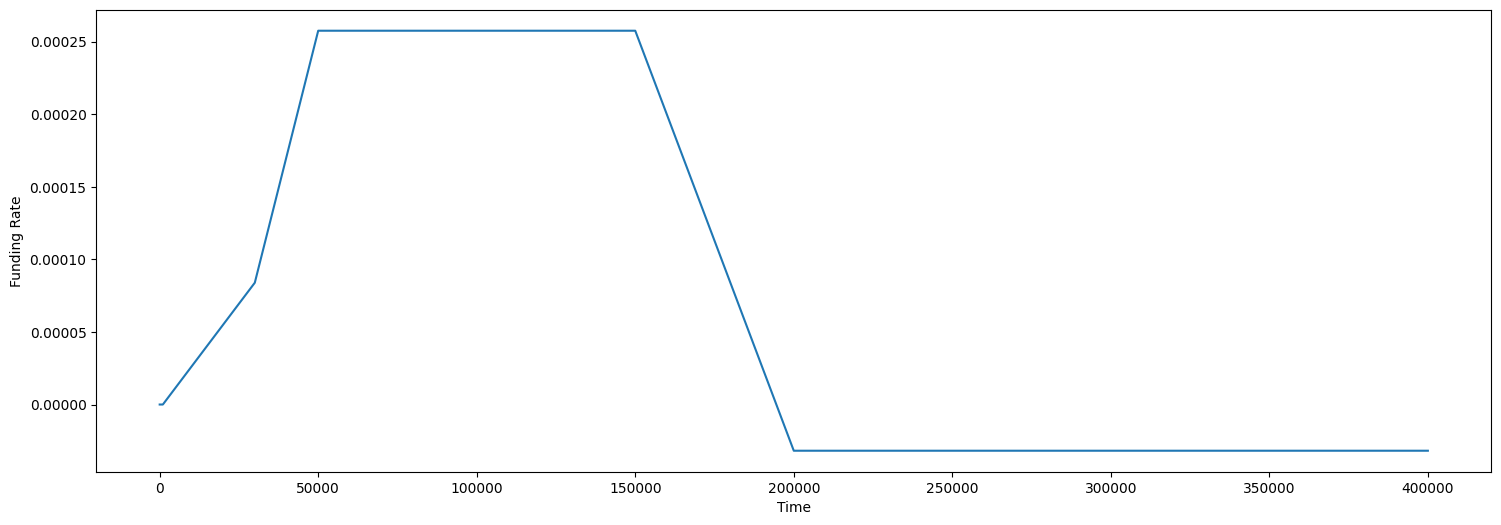

In [53]:
import matplotlib.pyplot as plt

sim_01a_res = simulation_01a(step=1000)

plt.subplots(figsize=(18, 6))
plt.plot(
    [x['t'] for x in sim_01a_res],
    [y['funding_rate'] for y in sim_01a_res],
)
plt.xlabel("Time")
plt.ylabel("Funding Rate")
plt.show()

## Funding Accrual

The behaviour of funding accrual will not change. It will behave the same as defined in SIP-80. The main benefit traders will see is a more stable funding rate. Let's visualise a position's funding rate

In [72]:
def ppint_sim_02_events(events, p1, p2) -> None:
    df = pd.DataFrame(events)
    pd.options.display.float_format = '{:,.2f}'.format
    display(df)

def sim_02(market, intervals, events, p1, p2, price):
    for interval in intervals:
        market.modify_position(interval['t'], interval['size_usd'])
        events.append({
            't': market.last_modified_at,
            'size': market.size,
            'skew': market.skew,
            'funding_rate': market.funding_rate,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued_p1_usd': market.funding_accrued_by_position(p1) * p1.size * price,
            'funding_accrued_p2_usd': market.funding_accrued_by_position(p2) * p2.size * price,
        })
    return events


def gen_empty_intervals_between(intervals, start, stop, step=1000) -> List:
    for t in range(start, stop, step):
        intervals.append({'t': t, 'size_usd': None})
    return intervals


def simulation_02(price=1000):
    market = Market(
        price=price,
        skew_scale_usd=FUNDING_VELOCITY_SCALE,
        max_funding_pct=MAX_FUNDING_VELOCITY,
    )

    # Let's trace 2 market positions and see how much they accrue.
    p1 = market.modify_position(0, -1_000_000)
    p2 = market.modify_position(0, 2_000_000)

    # Market is initially skewed long so the longs pay the shorts.
    events = [
        {
            't': 0,
            'size': 3000,
            'skew': 1000,
            'funding_rate': 0,
            'funding_velocity': market.funding_rate_velocity(),
            'funding_accrued_p1_usd': market.funding_accrued_by_position(p1) * p1.size * price,
            'funding_accrued_p2_usd': market.funding_accrued_by_position(p2) * p2.size * price,
        }
    ]

    intervals = []

    # Nothing happens between 1000s to 20,000s (skew 1M)
    gen_empty_intervals_between(intervals, 1000, 20_000)

    # New trader!
    #
    # Skew now at 0.5M
    intervals.append({'t': 21_000, 'size_usd': -500_000})

    gen_empty_intervals_between(intervals, 22_000, 30_000)

    # New trader!
    # 
    # The skew is now gone.
    intervals.append({'t': 31_000, 'size_usd': -500_000})

    gen_empty_intervals_between(intervals, 32_000, 50_000)

    # New trader!
    # 
    # the skew is now -5M
    intervals.append({'t': 51_000, 'size_usd': -5_000_000})

    gen_empty_intervals_between(intervals, 52_000, 80_000)

    # New trader!
    # 
    # Skew now at -1M
    intervals.append({'t': 81_000, 'size_usd': 4_000_000})

    gen_empty_intervals_between(intervals, 82_000, 120_000)

    # New trader!
    # 
    # Skew now at 10M
    intervals.append({'t': 121_000, 'size_usd': 11_000_000})

    gen_empty_intervals_between(intervals, 122_000, 150_000)

    # New trader!
    # 
    # Skew now at 0
    intervals.append({'t': 151_000, 'size_usd': -10_000_000})

    gen_empty_intervals_between(intervals, 152_000, 160_000)

    return sim_02(market, intervals, events, p1, p2, price), p1, p2

sim_02_res, p1, p2 = simulation_02()
ppint_sim_02_events(sim_02_res, p1, p2)

,t,size,skew,funding_rate,funding_velocity,funding_accrued_p1_usd,funding_accrued_p2_usd
0,0,"3,000.00","1,000.00",0.00,0.00,-0.00,0.00
1,1000,"3,000.00","1,000.00",0.00,0.00,-0.02,0.03
2,2000,"3,000.00","1,000.00",0.00,0.00,-0.07,0.13
3,3000,"3,000.00","1,000.00",0.00,0.00,-0.15,0.30
4,4000,"3,000.00","1,000.00",0.00,0.00,-0.27,0.54
...,...,...,...,...,...,...,...
149,155000,"34,000.00",0.00,0.00,0.00,205.31,-410.62
150,156000,"34,000.00",0.00,0.00,0.00,200.75,-401.51
151,157000,"34,000.00",0.00,0.00,0.00,196.20,-392.40
152,158000,"34,000.00",0.00,0.00,0.00,191.65,-383.29


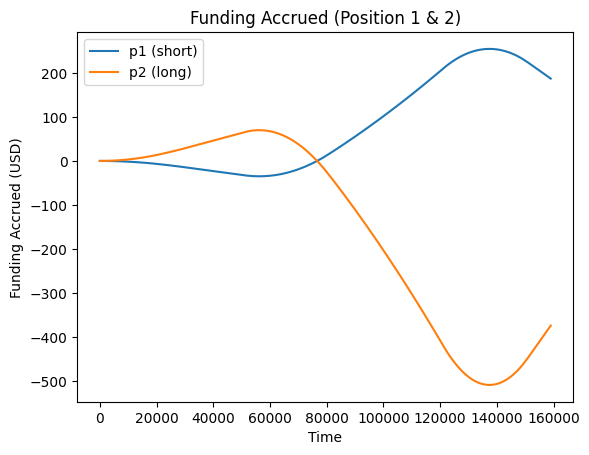

In [73]:
plt.plot(
    [x['t'] for x in sim_02_res],
    [y['funding_accrued_p1_usd'] for y in sim_02_res],
    label="p1 (short)"
)
plt.plot(
    [x['t'] for x in sim_02_res],
    [y['funding_accrued_p2_usd'] for y in sim_02_res],
    label="p2 (long)"
)

plt.title("Funding Accrued (Position 1 & 2)")
plt.xlabel("Time")
plt.ylabel("Funding Accrued (USD)")
plt.legend()
plt.show()